Данные https://www.kaggle.com/datasets/abhikjha/appa-real-face-cropped/code

Задача: Регрессия, определить возраст по фото. 

### 1. Установки библиотек, загрузка данных.

In [1]:
!pip install torch torchvision lightning torchmetrics timm -q

In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F
import torch.optim as optim

from optuna.samplers import TPESampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from sklearn.model_selection import train_test_split
from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping,Callback
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics import MeanAbsoluteError
from pathlib import Path

In [3]:
!kaggle datasets download -d abhikjha/appa-real-face-cropped

Dataset URL: https://www.kaggle.com/datasets/abhikjha/appa-real-face-cropped
License(s): unknown
 94%|██████████████████████████████████████▍  | 214M/228M [00:01<00:00, 170MB/s]
100%|█████████████████████████████████████████| 228M/228M [00:01<00:00, 183MB/s]


In [4]:
!unzip -q appa-real-face-cropped.zip -d /kaggle/working/

In [5]:
labels_path = '/kaggle/working/labels.csv'


images_path = '/kaggle/working/final_files/final_files/'

In [6]:
labels_df = pd.read_csv(labels_path)
sampled_labels = labels_df.sample(10)

In [7]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


/tmp/ipykernel_34/154353187.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_name = row[0]
/tmp/ipykernel_34/154353187.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age = row[1]


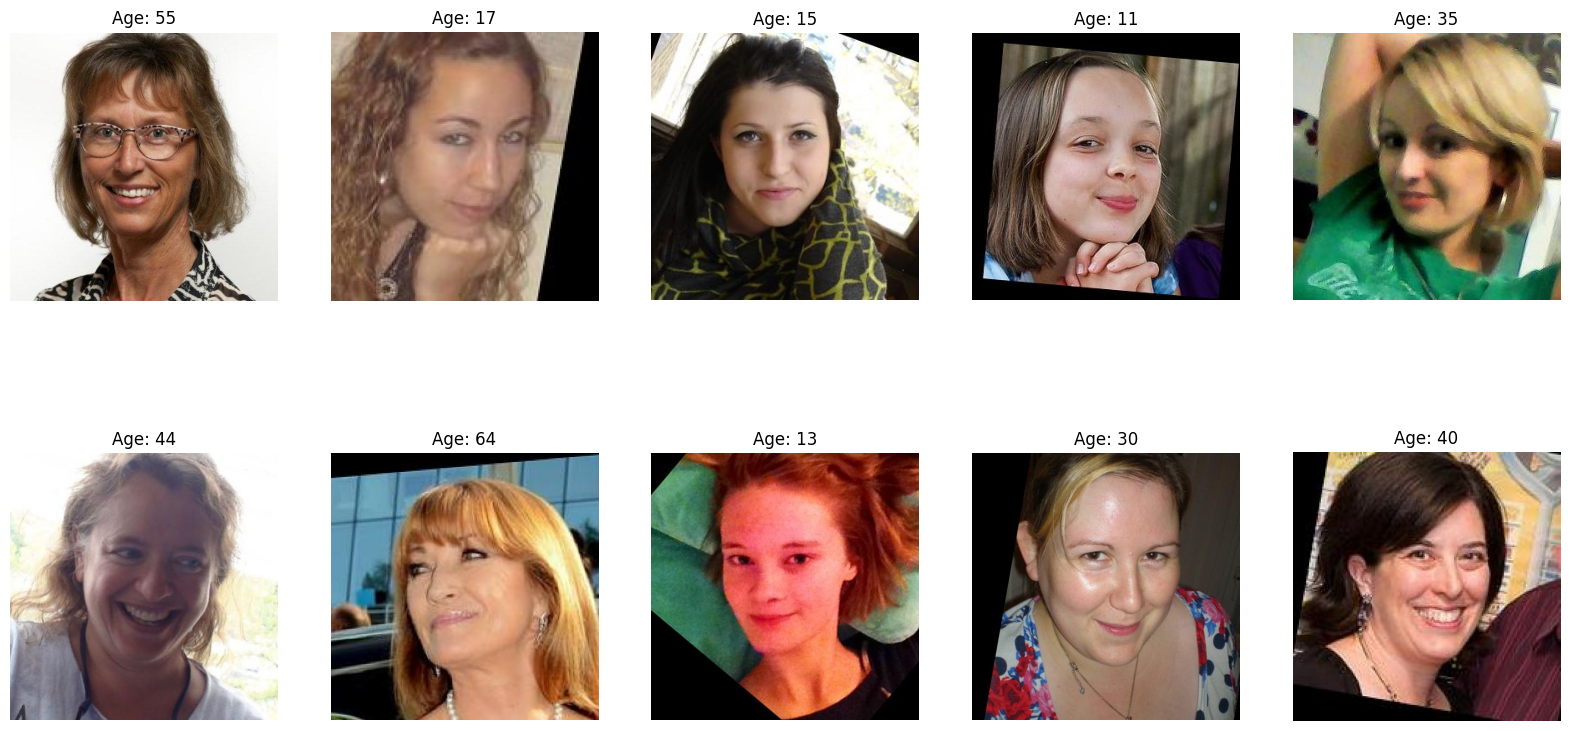

In [8]:
images = []
ages = []

for idx, row in sampled_labels.iterrows():
    img_name = row[0]
    age = row[1]
    img_path = os.path.join(images_path, img_name)
    img = Image.open(img_path)
    img = np.array(img)
    images.append(img)
    ages.append(age)

fig = plt.figure(figsize=(20, 10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(images[i])
    ax.set_title(f'Age: {ages[i]}')
    ax.axis('off')

plt.show()

Данные выгрузились нормально. Видно что в данные присутвует агментация, флипы и блюр. Для обучения модели это хорошо. 

### 2. Подготовка данных

Разделим данные на группы по возратам (градация ВОЗ). Посмотрим на распределение и позже используем этот признак для стратификации.

In [9]:
def age_group(age):
    if age < 1:
        return 'Новорожденные'
    elif 1 <= age < 6:
        return 'Маленькие дети'
    elif 6 <= age < 12:
        return 'Дети'
    elif 12 <= age < 18:
        return 'Подростки'
    elif 18 <= age < 45:
        return 'Молодые люди'
    elif 45 <= age < 60:
        return 'Средний возраст'
    elif 60 <= age < 75:
        return 'Пожилые'
    elif 75 <= age < 90:
        return 'Старики'
    else:
        return 'Долгожители'

In [10]:
labels_df['age_group'] = labels_df['real_age'].apply(age_group)
age_group_counts = labels_df['age_group'].value_counts().reset_index()
age_group_counts.columns = ['age_group', 'count']

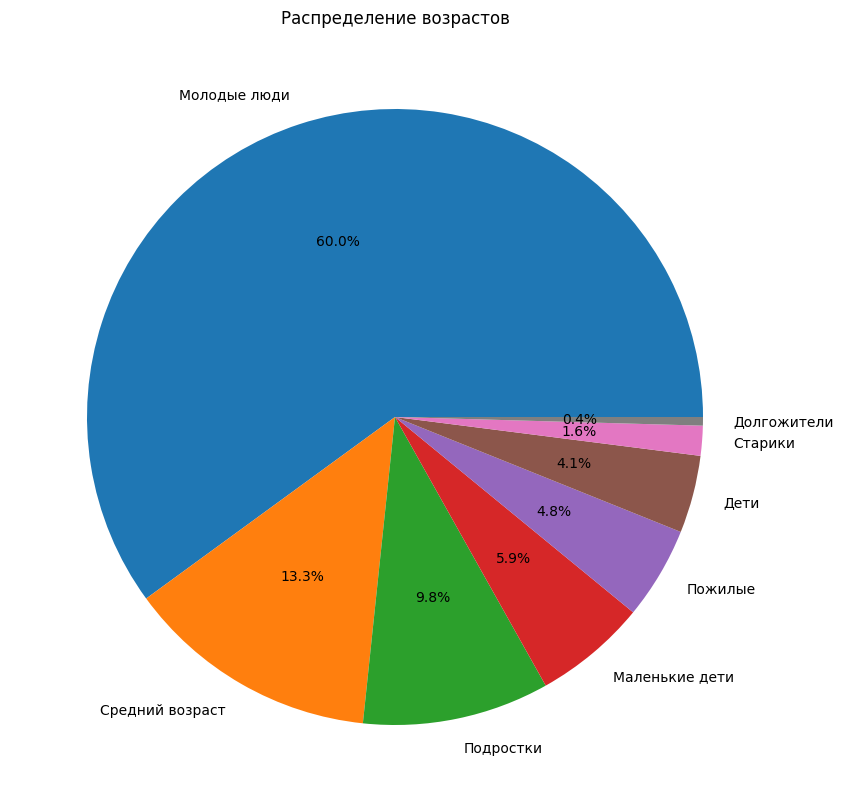

In [11]:
age_counts = labels_df['age_group'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(age_counts, labels = age_counts.index, autopct='%1.1f%%')
plt.title('Распределение возрастов')
plt.show()

Основную долю составляют моодые люди, что наверно логично, далее идут люди среднего возраста, подростки и остальные.  Стариков и долгожителей совесм мало, новорожденные нет. Для модели это хорошо, вероятно с маленкими детьми и очень пожилыми людьми будет больше всего ошибок. 

In [12]:
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['age_group'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['age_group'])

Напишем класс AgeDataset, для загрузки изображений и меток возрастов.
Для обработки изображений создадим transform, включающую изменение размера, преобразование в тензор и нормализацию.

In [13]:
class AgeDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[index, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Для воследующего анализа напишем логирование метрик на протяжении всего обучения, что бы сохранять метрики после каждой эпохи.

In [15]:
class MetricLogger(Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_mae = []
        self.val_mae = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics['train_loss_epoch'].item())
        self.train_mae.append(trainer.callback_metrics['train_mae_epoch'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_losses.append(trainer.callback_metrics['val_loss_epoch'].item())
        self.val_mae.append(trainer.callback_metrics['val_mae_epoch'].item())

После изучения доступных предобученных моделей и имея ввиду ограниченность ресурсов - выбрирал размер/производительность в тестах. TinyViT - показал лучший результат.  Класс AgeModel будет построен на базе модели из библиотеки timm, добавим слой dropout и полносвязный слой (для регресии) метрика MAE , параметры подбирал экспериментально ( не хватает ресурсов). Добавим так же динамический lr.

In [16]:
class AgeModel(LightningModule):
    def __init__(self, learning_rate=0.0001, weight_decay=0.01):
        super(AgeModel, self).__init__()
        self.model = timm.create_model("hf_hub:timm/tiny_vit_11m_224.dist_in22k_ft_in1k", pretrained=True)
        self.model.reset_classifier(num_classes=0)  
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.model.num_features * 7 * 7, 1)  
        self.criterion = nn.L1Loss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()

    def forward(self, x):
        x = self.model.forward_features(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs.squeeze(), labels)
        self.train_mae(outputs.squeeze(), labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_mae', self.train_mae, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs.squeeze(), labels)
        self.val_mae(outputs.squeeze(), labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_mae', self.val_mae, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs.squeeze(), labels)
        self.test_mae(outputs.squeeze(), labels)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('test_mae', self.test_mae, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=0.00001)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

    def predict_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        return outputs.squeeze(), labels

In [17]:
def train_and_evaluate_model(train_df, val_df, test_df, images_path, transform):
    import multiprocessing as mp
    mp.set_start_method('spawn', force=True)

    learning_rate = 0.0001
    batch_size = 64
    weight_decay = 0.01

    train_dataset = AgeDataset(train_df, images_path, transform=transform)
    val_dataset = AgeDataset(val_df, images_path, transform=transform)
    test_dataset = AgeDataset(test_df, images_path, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    model = AgeModel(learning_rate=learning_rate, weight_decay=weight_decay)

    logger = TensorBoardLogger('lightning_logs', name='age_prediction')

    metric_logger = MetricLogger()

    trainer = Trainer(
        max_epochs=30,
        accelerator='gpu',
        devices=1,
        logger=logger,
        log_every_n_steps=1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=8, mode='min'), metric_logger]
    )

    trainer.fit(model, train_loader, val_dataloaders=val_loader)

    model_save_path = 'age_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Модель сохранена в {model_save_path}')

    trainer.test(model, test_loader)

    model_save_path = Path(model_save_path)
    if not model_save_path.exists():
        raise FileNotFoundError(f"Файл модели {model_save_path} не существует")

    model.eval()
    true_values, predicted_values = [], []
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        true_values.extend(labels.numpy())
        predicted_values.extend(outputs.squeeze().detach().numpy())

    train_losses = metric_logger.train_losses
    val_losses = metric_logger.val_losses
    train_mae = metric_logger.train_mae
    val_mae = metric_logger.val_mae

    min_length = min(len(train_losses), len(val_losses), len(train_mae), len(val_mae))
    train_losses = train_losses[:min_length]
    val_losses = val_losses[:min_length]
    train_mae = train_mae[:min_length]
    val_mae = val_mae[:min_length]
    epochs = range(1, min_length + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_mae, label='Train')
    ax1.plot(epochs, val_mae, label='Validation')
    ax1.set_title('Metrics')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MAE')
    ax1.legend()

    ax2.plot(epochs, train_losses, label='Train')
    ax2.plot(epochs, val_losses, label='Validation')
    ax2.set_title('Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

    return trainer, model, test_loader, true_values, predicted_values, str(model_save_path)

Добавим визуализацию ошибок 

In [18]:
def visualize_predictions(true_values, predicted_values):
    errors = np.array(predicted_values) - np.array(true_values)

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    axs[0].plot(list(range(len(true_values))), true_values, color='green', label='Истинные')
    axs[0].plot(list(range(len(predicted_values))), predicted_values, color='red', label='Предсказанные')
    axs[0].set_title('Истинные vs Предсказанные')
    axs[0].set_xlabel('Индекс')
    axs[0].set_ylabel('Значение')
    axs[0].legend()

    axs[1].hist(errors, color='blue', bins=30)
    axs[1].set_title('Распределение ошибки')
    axs[1].set_xlabel('Ошибка')
    axs[1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

И посмотрим фото с самыми большим ошибками. 

In [19]:
def visualize_images_with_errors(test_df, images_path, true_values, predicted_values, threshold=15):
    errors = np.abs(np.array(predicted_values) - np.array(true_values))
    large_errors_indices = np.where(errors > threshold)[0]
    
    for idx in large_errors_indices:
        img_name = os.path.join(images_path, test_df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        true_value = true_values[idx]
        predicted_value = predicted_values[idx]
        
        plt.figure()
        plt.imshow(image)
        plt.title(f'Истинное: {true_value}, Предсказанное: {predicted_value}')
        plt.axis('off')
        plt.show()

config.json:   0%|          | 0.00/598 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/44.1M [00:00<?, ?B/s]

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2024-06-17 11:49:32.875671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 11:49:32.875800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 11:49:33.147619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | TinyVit           | 10.5 M | train
1 | dropout   |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Модель сохранена в age_model.pth


/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │     5.371530055999756     │
│      test_mae_epoch       │     5.371530532836914     │
└───────────────────────────┴───────────────────────────┘

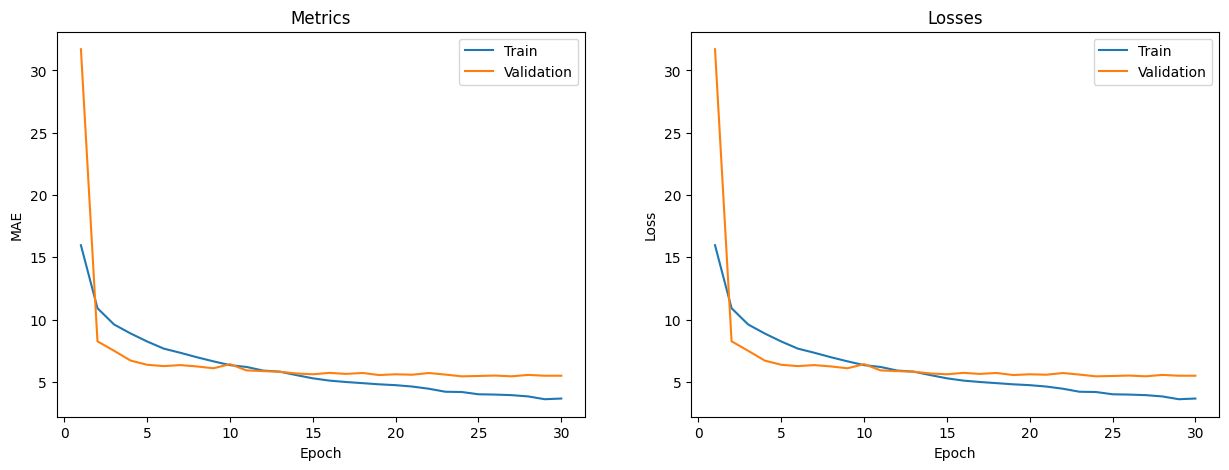

In [20]:
trainer, model, test_loader, true_values, predicted_values, model_save_path = train_and_evaluate_model(
    train_df, val_df, test_df, images_path, transform
)

Даже маленькая модель переобучается. Как я не настраивал dropout и L2(weight_dacay) - это лучшие резульаты. Модель или хуже обучается или в итоге имеет большую ошибку на тесте. Данных мало конечно, но хорошо что есть аугментация. 

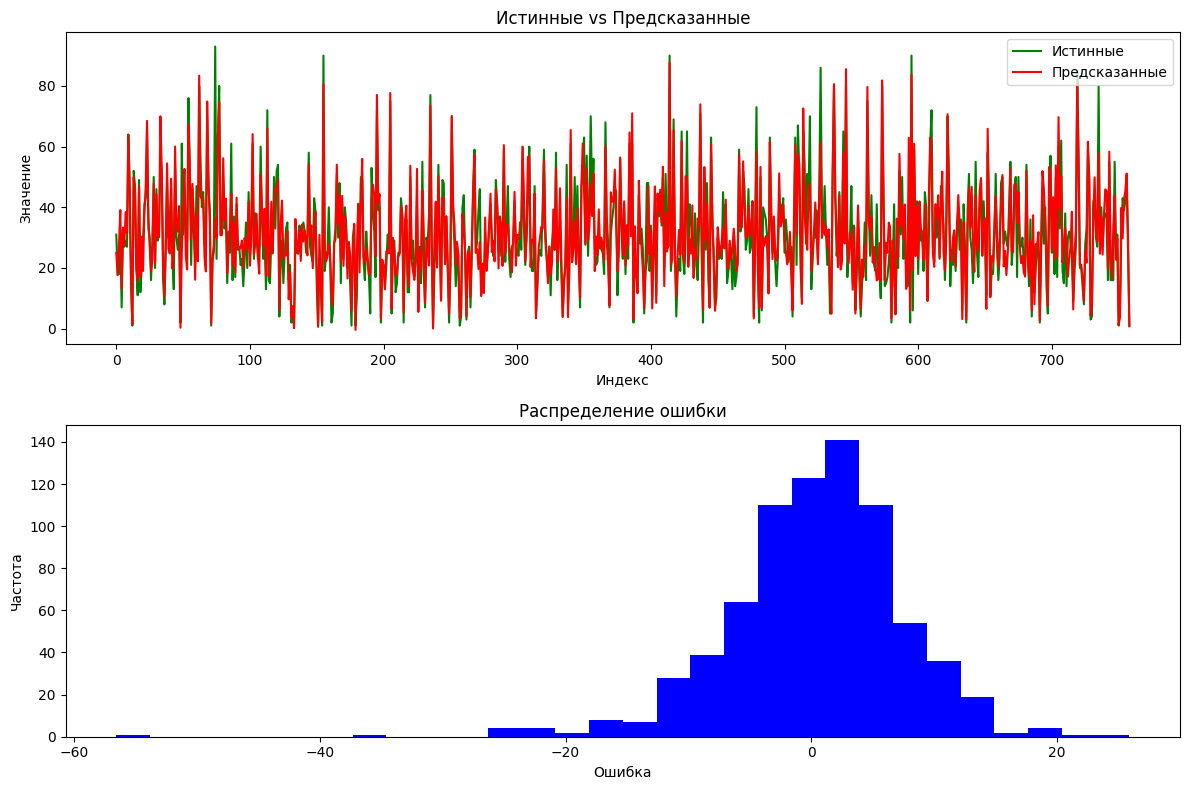

In [21]:
visualize_predictions(true_values, predicted_values) 

Видим что модель в целом справляется очень даже хорошо, ошибка нормально распределена со средним около 0 и редко превышает 10.

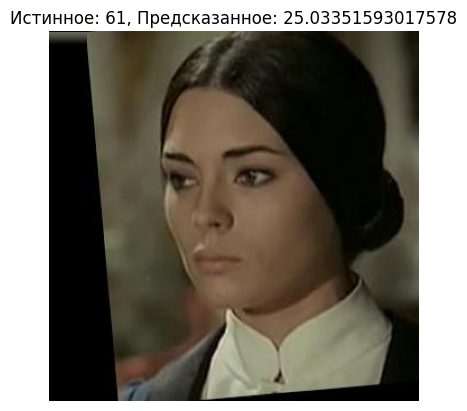

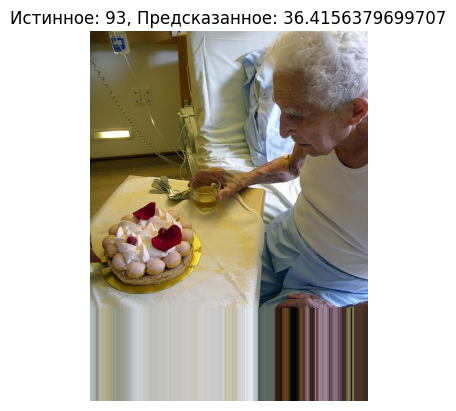

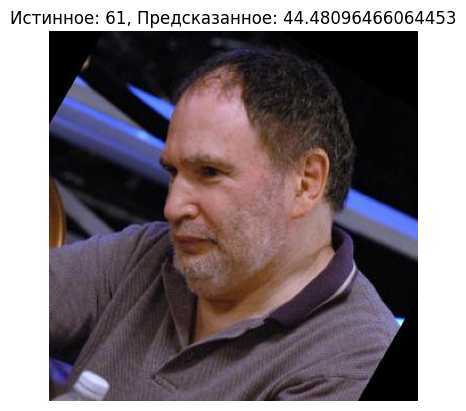

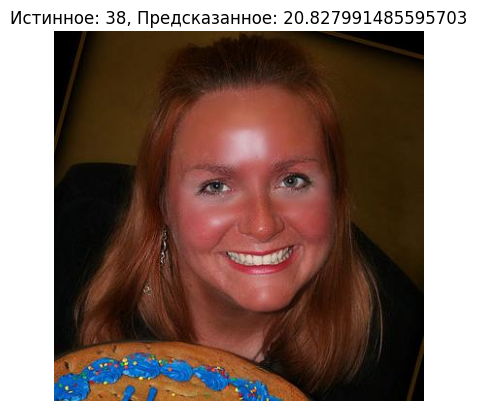

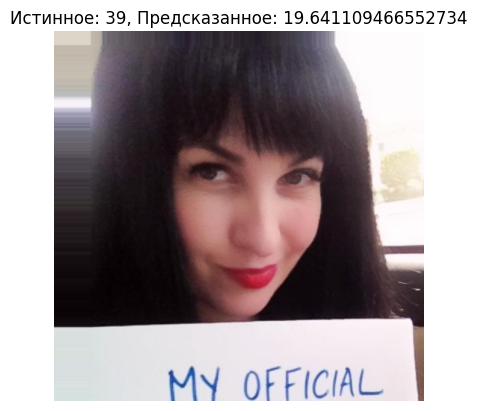

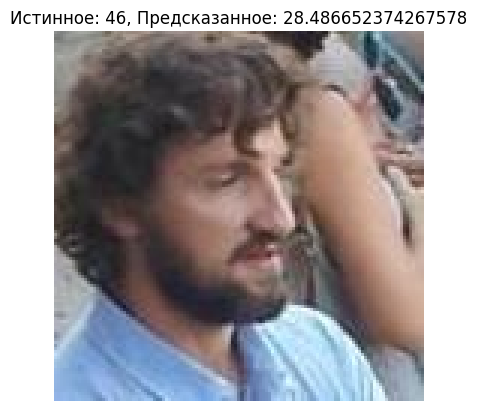

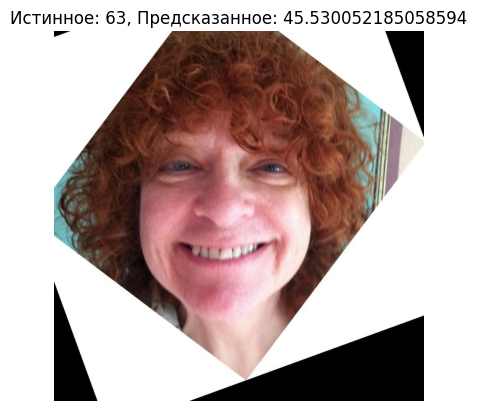

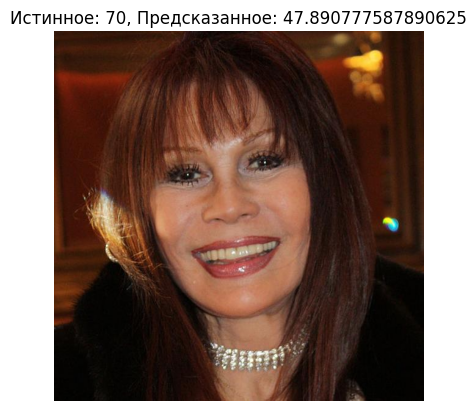

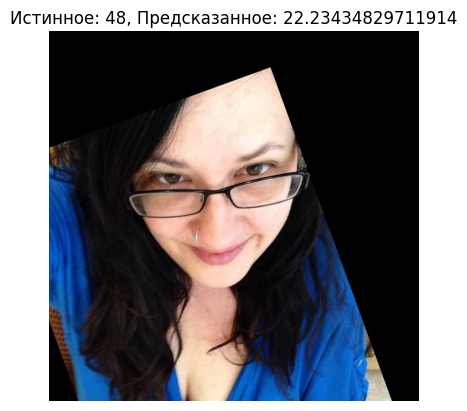

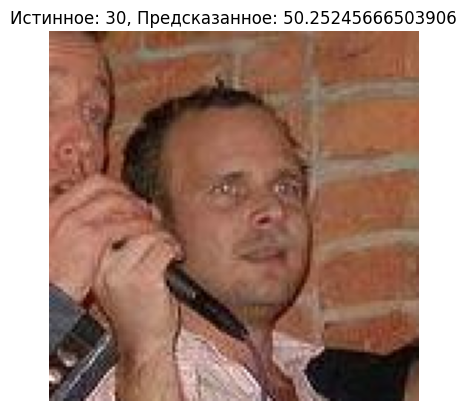

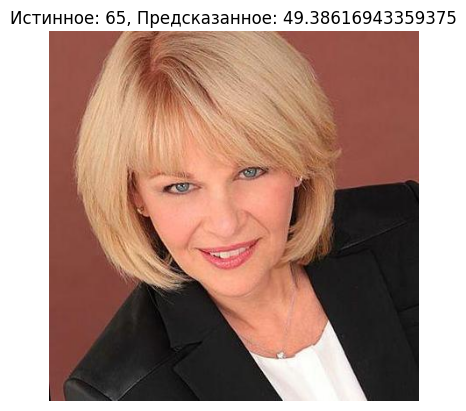

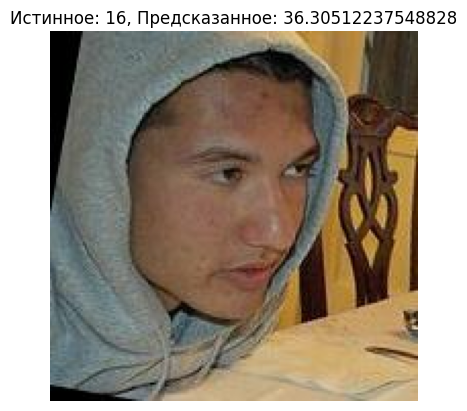

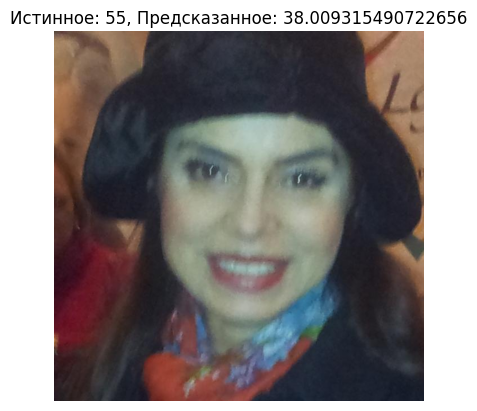

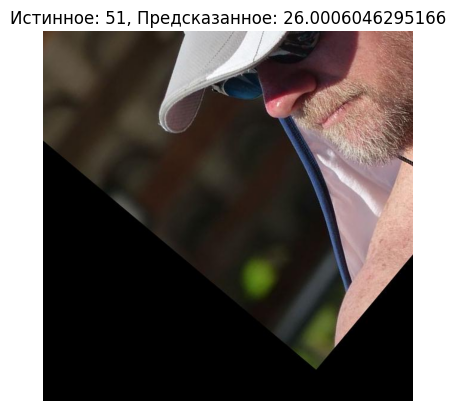

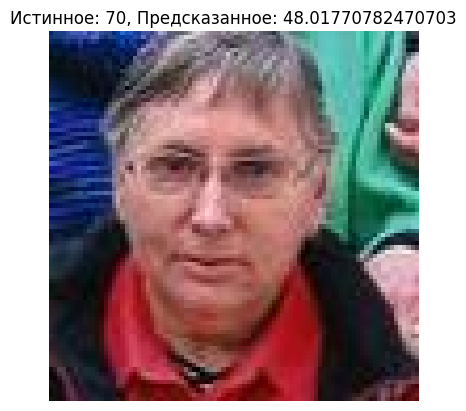

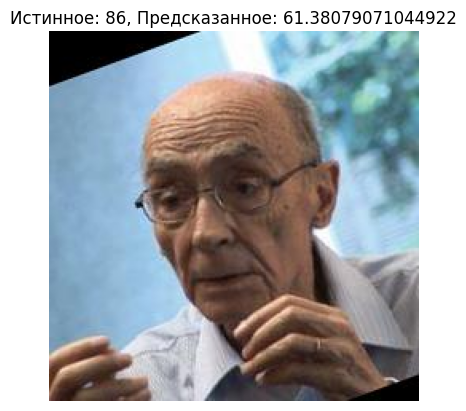

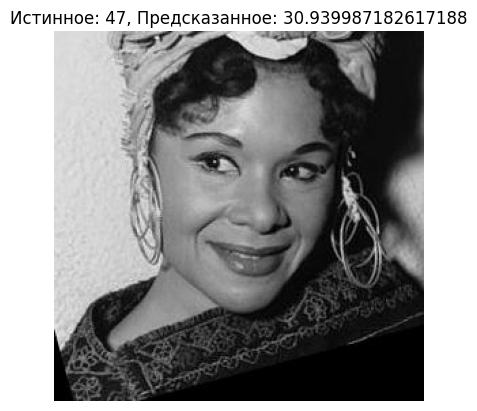

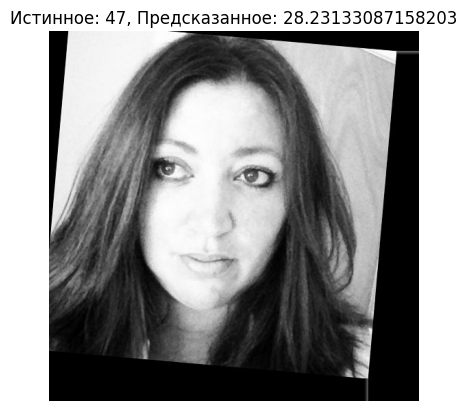

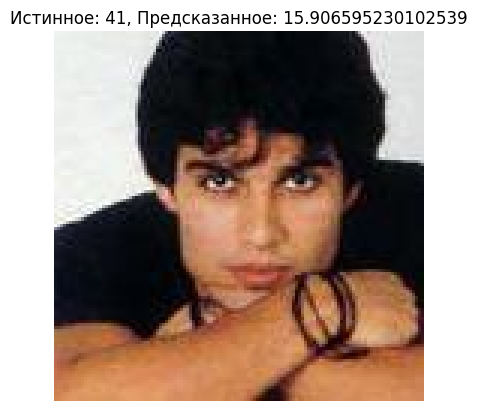

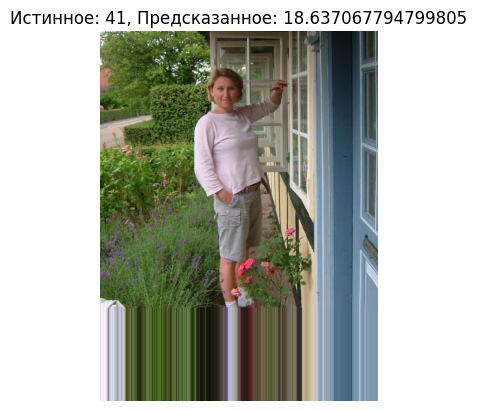

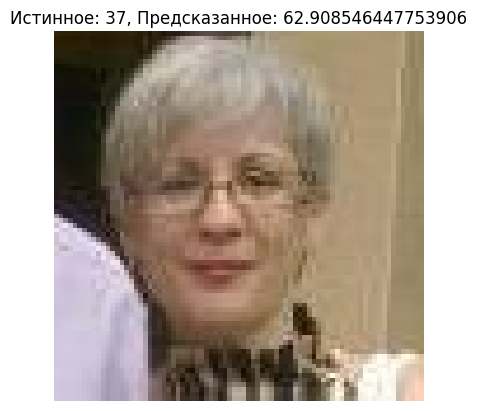

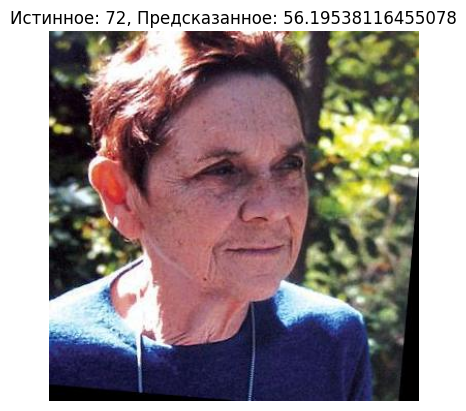

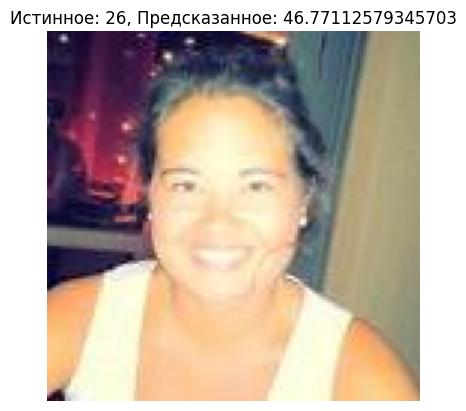

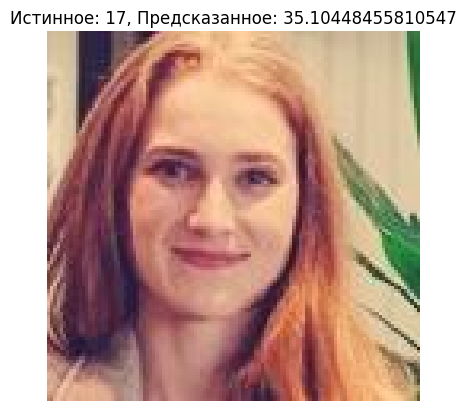

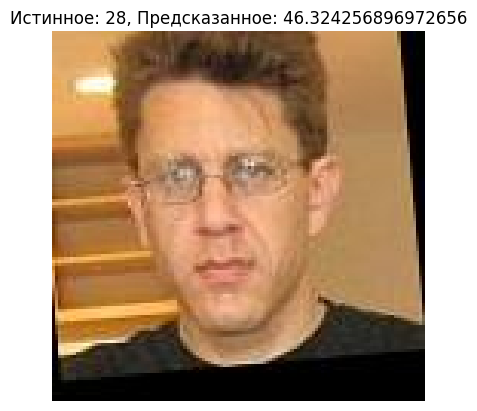

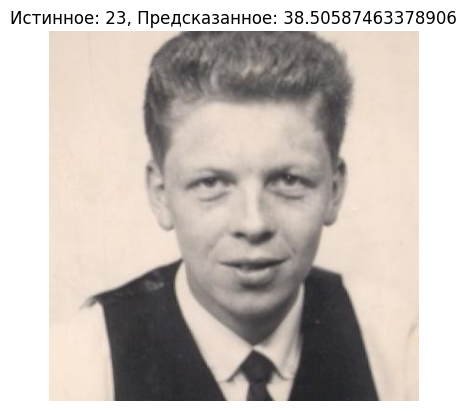

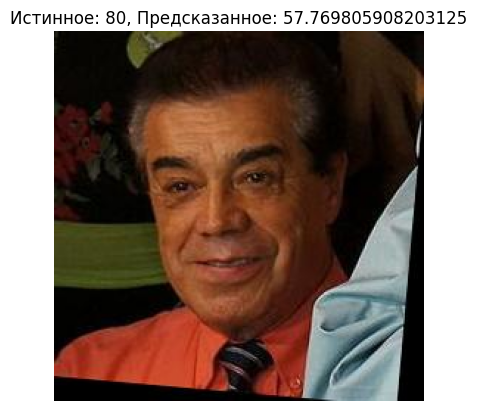

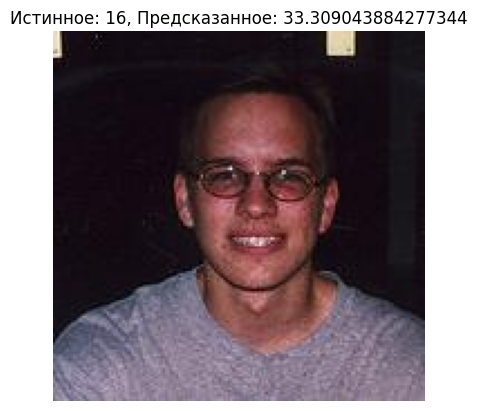

In [22]:
visualize_images_with_errors(test_df, images_path, true_values, predicted_values)

Хорошая работа. Видно что фото с ошибкой больше 15 - или сложно различимы из за блюра или у людей на фото действительно сложно предсказать реальный возраст, они выглядет старше/моложе своих лет. Не вижу действительно серьезных, явных ошибок ошибок. Разве что второе фото вызывает вопросы. Тут как раз модель плохо сработала.

In [23]:
from IPython.display import FileLink
display(FileLink(model_save_path))

/kaggle/working/age_model.pth

Мы предсказвали возраст по фото, набор данных оказался очень сложный. Уже присутсвтует аугментация, местами очень явная,  возрастные группы распределены не равномерно. Ипользовали модель TinyViT , которая показала достаточно хороший результат. Параметры подбирали экпериментально. 
Итоговый mae = 5.3

Что бы улучшить результат нужно использовать более мощные большие предобученные модели с полным подбором параметров. 